In [3]:
import numpy as np
%matplotlib inline
import Corrfunc
import glob
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import nbodykit

import utils
import plotter
import bao_utils

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load_data(cat_tag, cf_tag, Nrealizations=100, return_amps=False):
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    xis = []
    amps = []
    n_converged = 0

    for Nr in range(Nrealizations):

        if 'baoiter' in cf_tag:
            fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
            matches = glob.glob(f'{result_dir}/{fn_pattern}')
            for cf_fn in matches:
                r_avg, xi, amp, _, _ = np.load(cf_fn, allow_pickle=True)
                n_converged +=1
                break #should only be 1 match; but probs better way to do this
            if len(matches)==0:
                continue
        else:
            cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tag, cat_tag, Nr)
            r_avg, xi, amp, proj, extra = np.load(cf_fn, allow_pickle=True)
        rs.append(r_avg)
        xis.append(xi)
        amps.append(amp)
        
    if 'baoiter' in cf_tag:
        print(f'Number converged: {n_converged}/{Nrealizations}')
        
    if return_amps:
        return rs, xis, amps
    else:
        return rs, xis

In [5]:
def load_true(cat_tag, bias=1.0):
    cat_dir = '../catalogs'
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    xi_true *= bias**2
    return r_true, xi_true

In [6]:
def plot_cf_err(rs, cf_arrs, r_true, cf_true, labels, colors, err=False, xlim=None, errlim=None, cont=True, bases=None):
    
    if np.array(rs).ndim == 1:
        rs = [rs]
    if np.array(cf_arrs).ndim == 2:
        cf_arrs = np.array([cf_arrs])
    
    cfs_mean = []
    error_regions = []
    for cfs in cf_arrs:
        mean = np.mean(cfs, axis=0)
        cfs_mean.append(mean)
        std = np.std(cfs, axis=0)
        error_regions.append([mean-std, mean+std])
    
    ax = plotter.plot_cf_cont(rs, cfs_mean, r_true, cf_true, labels, colors, error_regions=error_regions, 
                         err=err, xlim=xlim, errlim=errlim, cont=cont, bases=bases)
    return ax

In [7]:
def plot_continuous(cat_tag, cf_tags, Nrealizations=100, colors=None, labels=None, err=True, errlim=None, 
                    cont=True, show_bases=True, xlim=None, peak_fit=False, bws=[], r_widths=[], r_max_true=None, b1=2.0):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]
    if xlim is None:
        xlim = [40.0, 148.0]
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    r_arrs = []
    cf_arrs = []
    bases = None
    if show_bases:
        bases = []

    for i in range(len(cf_tags)):
        cf_tag = cf_tags[i]
        xis = []
        rarr = []
        n_converged = 0

        rarr, xis = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations, return_amps=False)
        #rarr.append(r_avg)
        #xis.append(xi)
        r_avg = rarr[0]
        rs.append(r_avg)
        r_arrs.append(rarr)
        cf_arrs.append(xis)     

        if show_bases:
            if 'tophat' in cf_tag:
                rmin = min(r_avg)
                rmax = max(r_avg)
                binwidth = float(cf_tag.split('bw')[-1])
                r_edges = np.arange(rmin, rmax+binwidth, binwidth)
                base = np.zeros((len(r_avg), len(r_edges))) #r_edges - 1 (bc edges not bins), +1 (bc ravg)
                base[:,0] = r_avg
                for rr in range(len(r_edges)-1):
                    base[:,rr+1] = [1.0 if r_edges[rr]<=r_avg[jj]<r_edges[rr+1] else 0.0 for jj in range(len(r_avg))]
            else:
                if 'baoiter' in cf_tag:
                    rmin, rmax = 36.0, 200.0
                    redshift = 0.57
                    bias = 2.0
                    projfn = f'../tables/bases{cf_tag}_r{rmin}-{rmax}_z{redshift}_bias{bias}.dat'
                else:
                    projfn = f'../tables/bases{cf_tag}.dat'
                base = np.loadtxt(projfn)
                bmax = max(np.array([base[bb,1:] for bb in range(base.shape[0]) if xlim[0]<base[bb,0]<xlim[1]]).flatten())
                base[:,1:] /= bmax   
            bases.append(base)        
        
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    xi_true *= b1**2

    ax = plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, xlim=xlim, 
                errlim=errlim, cont=cont, bases=bases)
    
    if peak_fit:
        r_peak_guess = 100.0
        r_peak_arr, *_ = find_peaks_center(r_arrs, cf_arrs, r_peak_guess, bws=bws, r_widths=r_widths)
        for i in range(len(cf_tags)):
            r_med = np.nanmedian(r_peak_arr[i])
            r_p16 = np.nanpercentile(r_peak_arr[i], 16)
            r_p84 = np.nanpercentile(r_peak_arr[i], 84)
            ax[0].errorbar(r_med, 0.008+i*0.001, xerr=[[r_med-r_p16], [r_p84-r_med]], fmt='o', 
                           color=colors[i], markersize=4)
        if r_max_true is not None:
            ax[0].errorbar(r_max_true, 0.008-0.001, fmt='o', color='k', markersize=4)
        return ax, r_peak_arr
    else:
        return ax

In [8]:
# deriv: 2ax + b = 0
# x = -b/(2a)
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

In [9]:
def find_peaks_center(r_arr, xi_arr, rpeak_guess, bws, r_widths=[11.0], region=(85,115), show_bad=False):
    xi_arr = np.array(xi_arr)
    if len(xi_arr.shape)<3:
        r_arr = [r_arr]
        xi_arr = [xi_arr]
        
    ntags = np.array(xi_arr).shape[0]
    N = np.array(xi_arr).shape[1]
    n_nans_tot = 0
    
    if show_bad:
        plt.figure()
        #plt.ylim(-0.01, 0.05)
        plt.xlim(36, 156)
    
    r_peak_arr = np.zeros((ntags, N))
    for i in range(ntags):
        bw = bws[i]
        r_width = r_widths[i]

        rs = r_arr[i]
        xis = xi_arr[i]
        
        n_nans = 0
        n_botedge = 0
        n_topedge = 0
        #r_maxes = []
        #r_peaks = []
        for j in range(N):
            r = rs[j]
            xi = xis[j]

            xi_func = interp1d(r, xi, kind='cubic')
            
            r_edges = np.arange(min(r), max(r)+bw, bw)
            r_avg = 0.5*(r_edges[:-1] + r_edges[1:])
            
            r_points = r_avg[np.where(np.abs(r_avg-rpeak_guess)<r_width)]
            assert len(r_points)>2, "Bad points! <3"
            
            xi_points = [xi_func(rp) for rp in r_points]
            popt, _ = curve_fit(quadratic, r_points, xi_points)
            a, b, c = popt

            if a>0:
                r_peak_arr[i][j] = np.random.choice(region)
                if show_bad:
                    plt.plot(r, xi+n_nans_tot*0.005)
                n_nans += 1
                n_nans_tot += 1
                continue

            r_peak = -b/(2*a)
            if r_peak<region[0]:
                r_peak=region[0]
                n_botedge +=1
            elif r_peak>region[1]:
                r_peak=region[1]
                n_topedge += 1
            r_peak_arr[i][j] = r_peak
#             if r_peak<region[0] or r_peak>region[1]:
#                 r_peak = np.NaN
#                 n_nans += 1
            r_peak_arr[i][j] = r_peak 
        #r_peak_arr.append(np.array(r_peaks))
        
        print('Number of NaNs:', n_nans, ', Bottom edges:', n_botedge, ', Top edges:', n_topedge)
     
    if show_bad:
        plt.ylim(-0.01, n_nans/45.)
    return r_peak_arr, r_points, xi_points, popt

In [10]:
ctopmany = '#33BBEE'
ctopmid = '#3547F1'
ctopfew = '#0077BB'
cspline = '#EE3377'
cbao = '#228833'
ctheory = '#808080'

In [9]:
cosmo_b17 = bao_utils.get_cosmo('b17')
cosmo_patchy = bao_utils.get_cosmo('patchy')

z = 0.57
alpha_true = bao_utils.compute_alpha(z, cosmo_patchy, cosmo_b17) #1st is truth, 2nd is fiducial

Omega0_m_patchy = cosmo_patchy.Omega0_cdm + cosmo_patchy.Omega0_b
r_s = bao_utils.compute_radius_sound_horizon(Omega0_m_patchy, cosmo_patchy.Omega0_b, cosmo_patchy.h)

0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06] 0.824 2.0328
0.258909 0.307115 0.048206 0.6777 0.9611 [] 0.8288000000000002 3.046
0.307115 0.258909 0.048206 0.6777
0.31000013381653335 0.260448 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.63251902228856 D_A: 1388.2262919973946 Mpc H: 92.93687764109468 km / (Mpc s)
rs_truth_col 150.53793048861854 rs_fid_col 150.51468231796673
alpha: 0.998656590432877
alpha_col: 0.998798086203619


Number of NaNs: 0 , Bottom edges: 0 , Top edges: 0
True r_s: 102.79179254371591
Found peak: 100.0907944285601


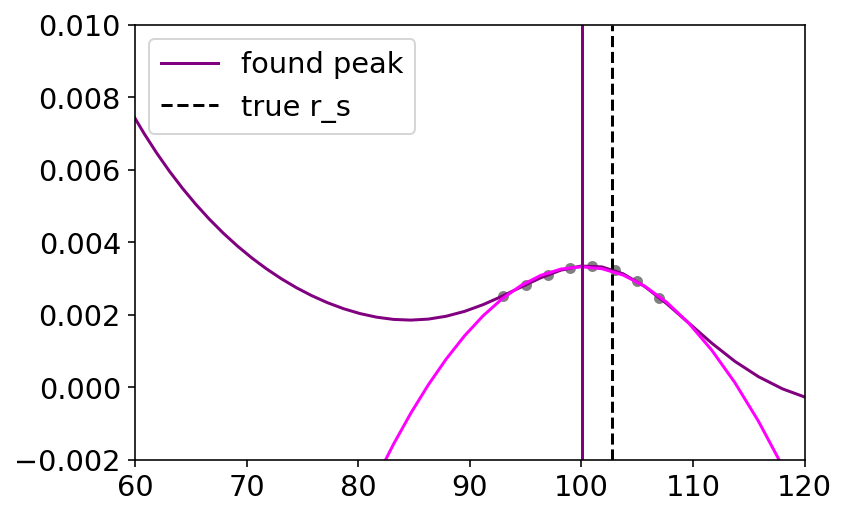

In [10]:
cat_tag = '_L750_n2e-4_z057_patchy'
r_true, xi_true = load_true(cat_tag, bias=2.0)
rpeak_guess = 100.0
bw = 2
r_peak_arr, r_points, xi_points, popt = find_peaks_center([r_true], [xi_true], rpeak_guess, bws=[bw], r_widths=[8.0])
r_max_true = r_peak_arr[0][0]

plt.figure()
color = 'purple'
plt.plot(r_true, xi_true, color=color)
plt.plot(r_true, quadratic(r_true, *popt), color='magenta')
plt.scatter(r_points, xi_points, marker='o', s=20, color='grey')
plt.axvline(r_max_true, color=color, label='found peak')
plt.axvline(r_s*cosmo_patchy.h, color='black', ls='--', label='true r_s')

plt.legend()
plt.xlim(60, 120)
plt.ylim(-0.002, 0.01)

print("True r_s:", r_s*cosmo_patchy.h)
print("Found peak:", r_max_true)

# Spline basis

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


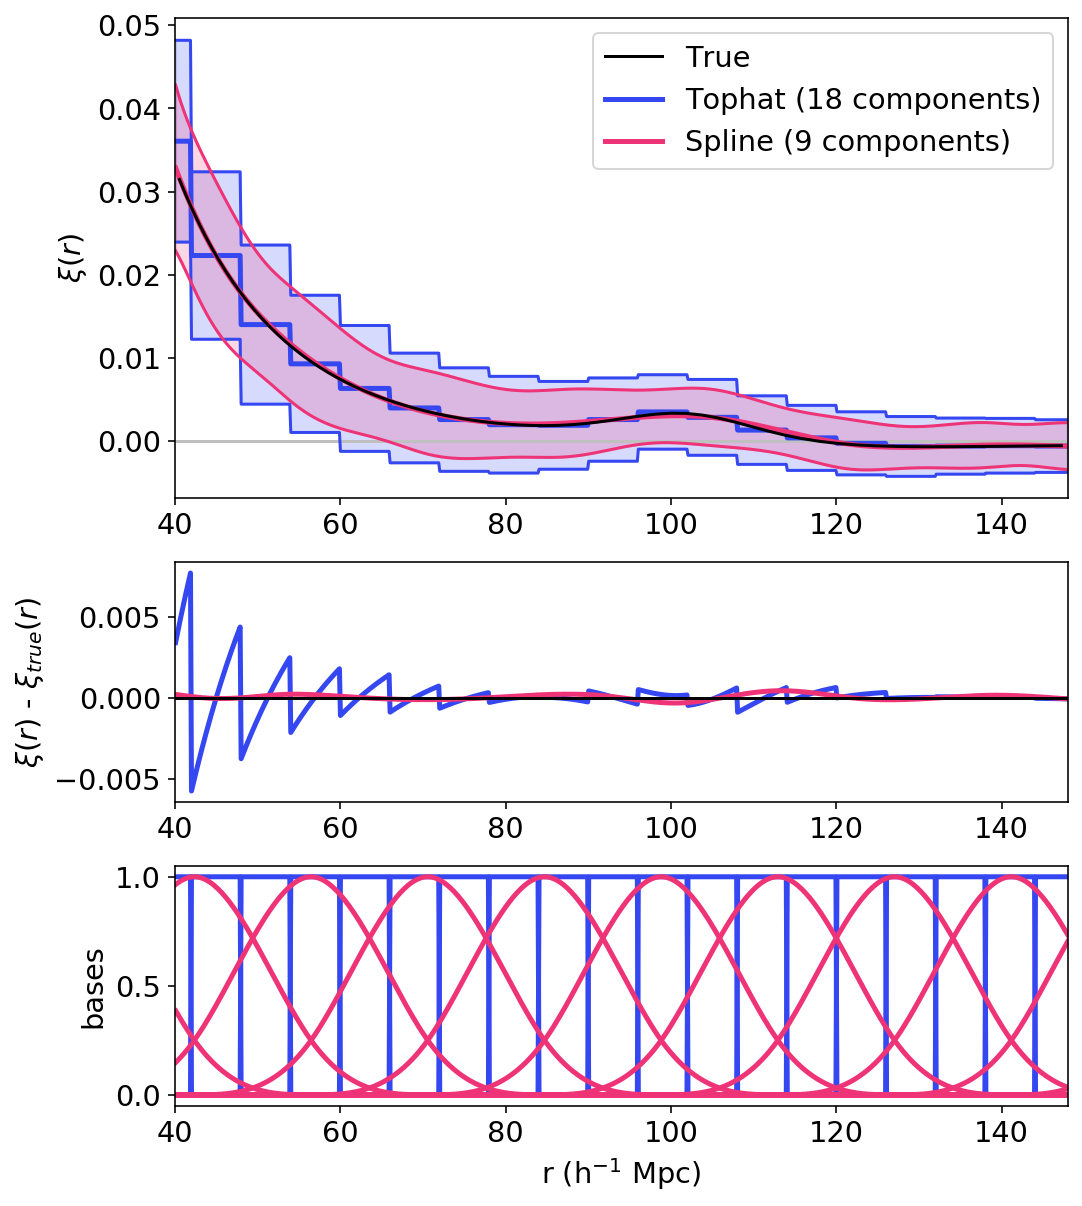

In [22]:
cat_tag = '_L750_n2e-5_z057_patchy'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmid, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


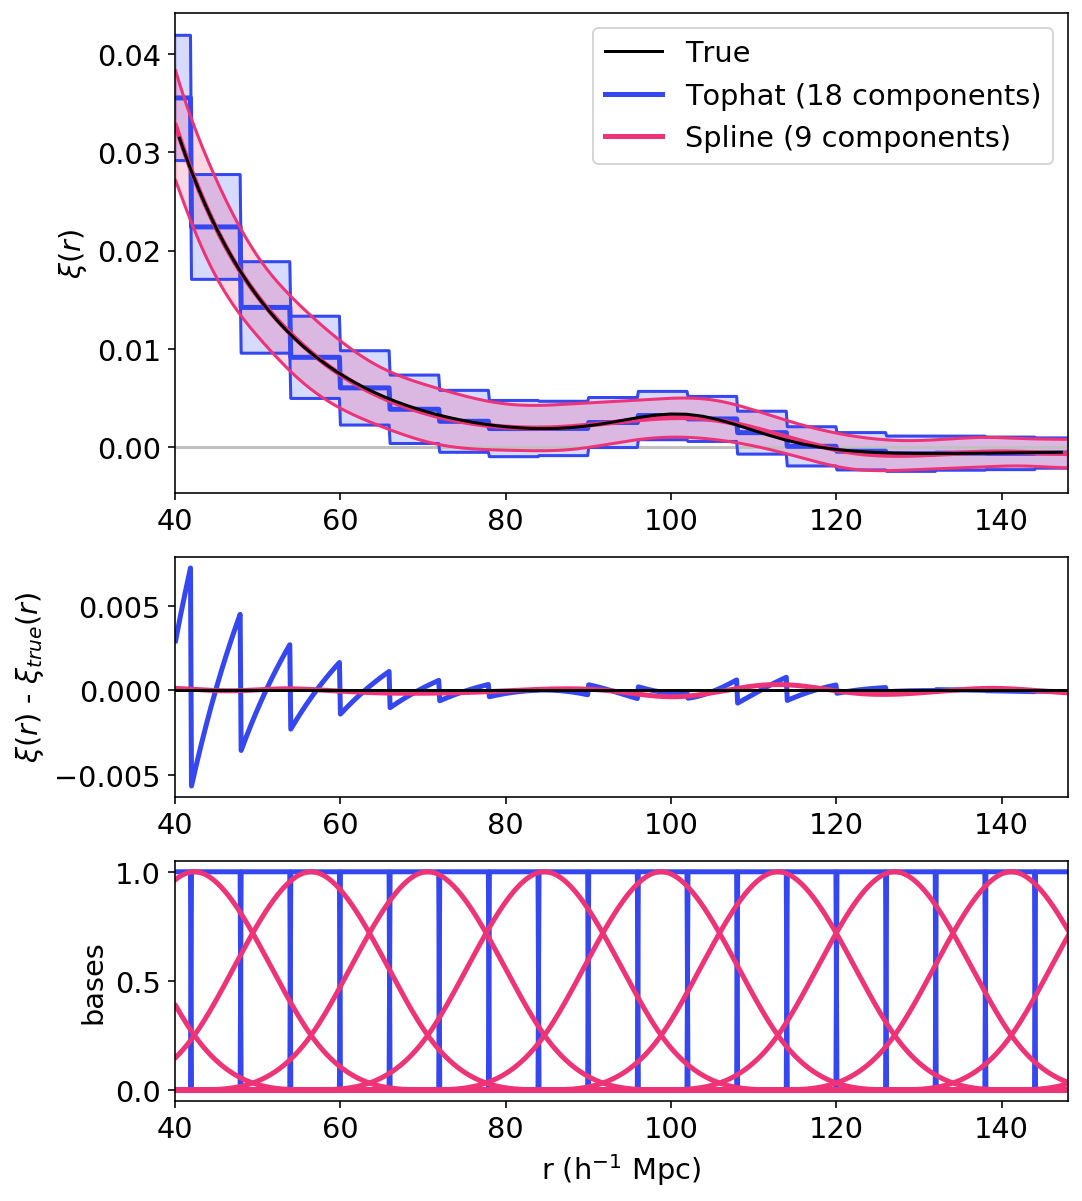

In [23]:
cat_tag = '_L750_n5e-5_z057_patchy'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmid, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


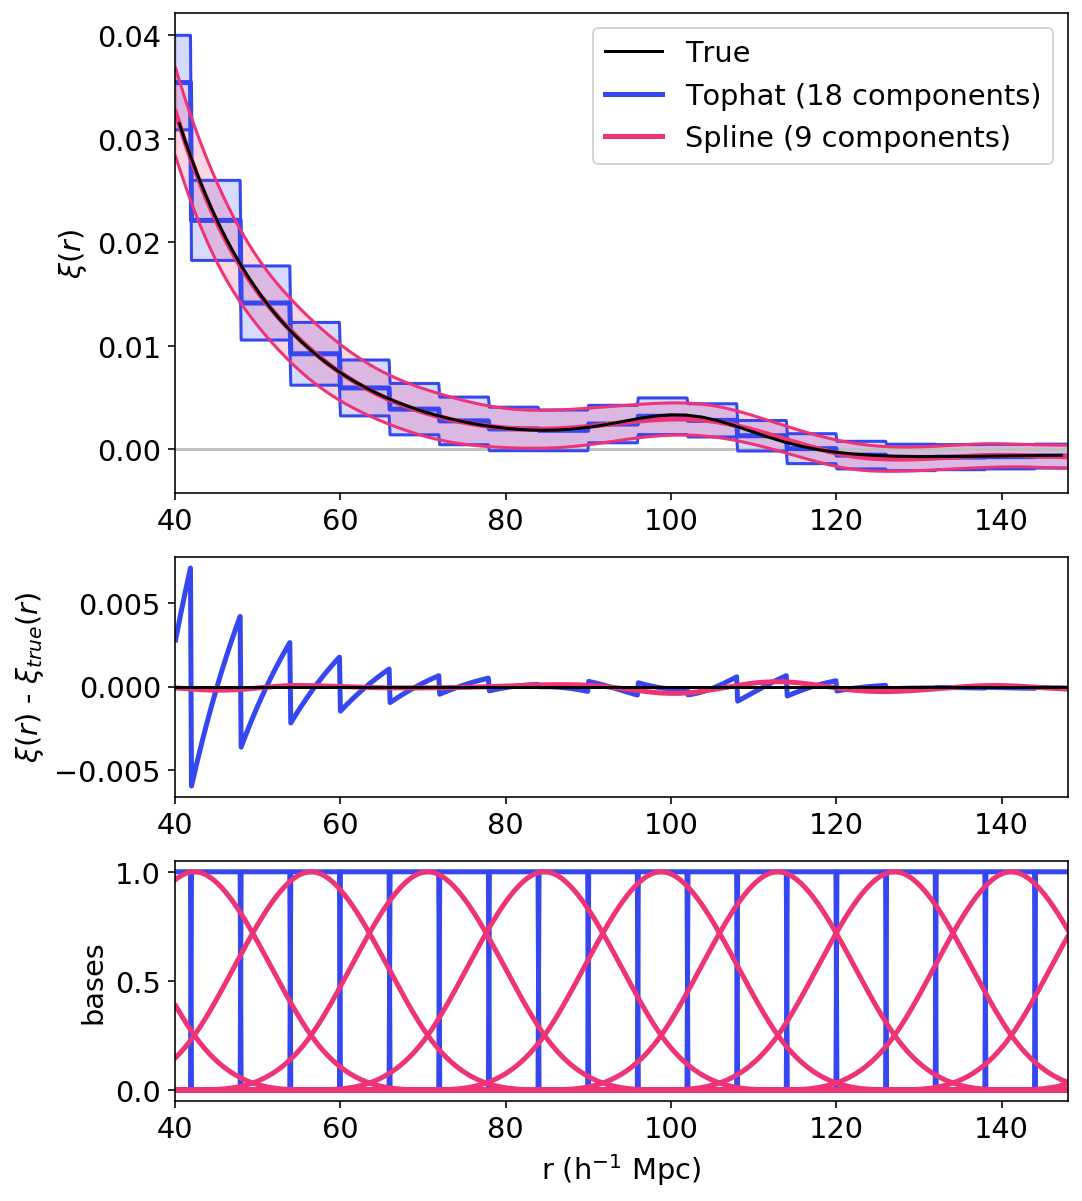

In [24]:
cat_tag = '_L750_n1e-4_z057_patchy'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmid, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

### n = 2e-4

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


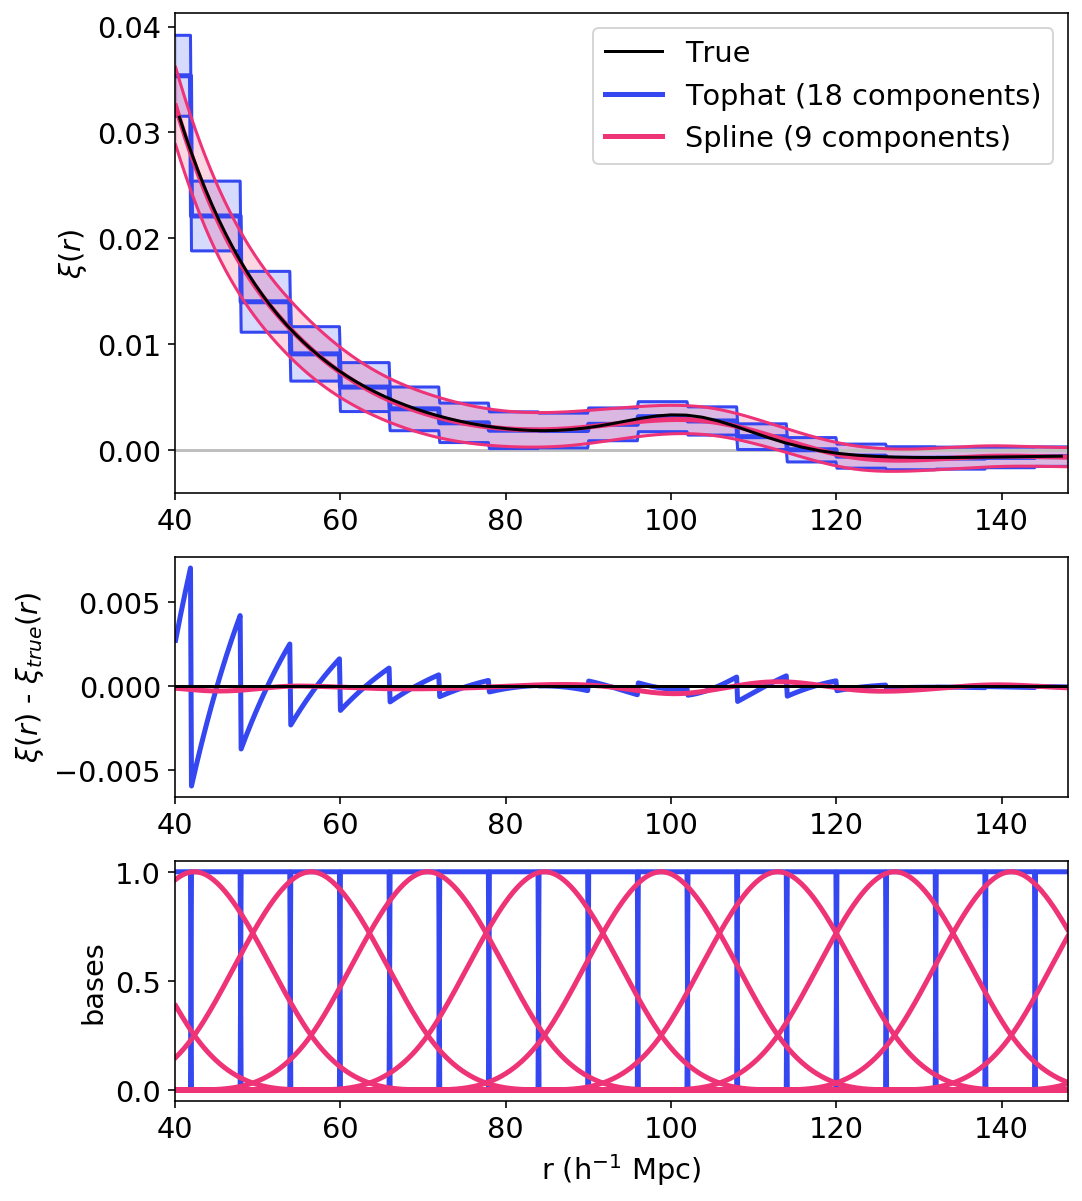

In [21]:
cat_tag = '_L750_n2e-4_z057_patchy'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmid, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

## BAO iterative

Number converged: 894/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


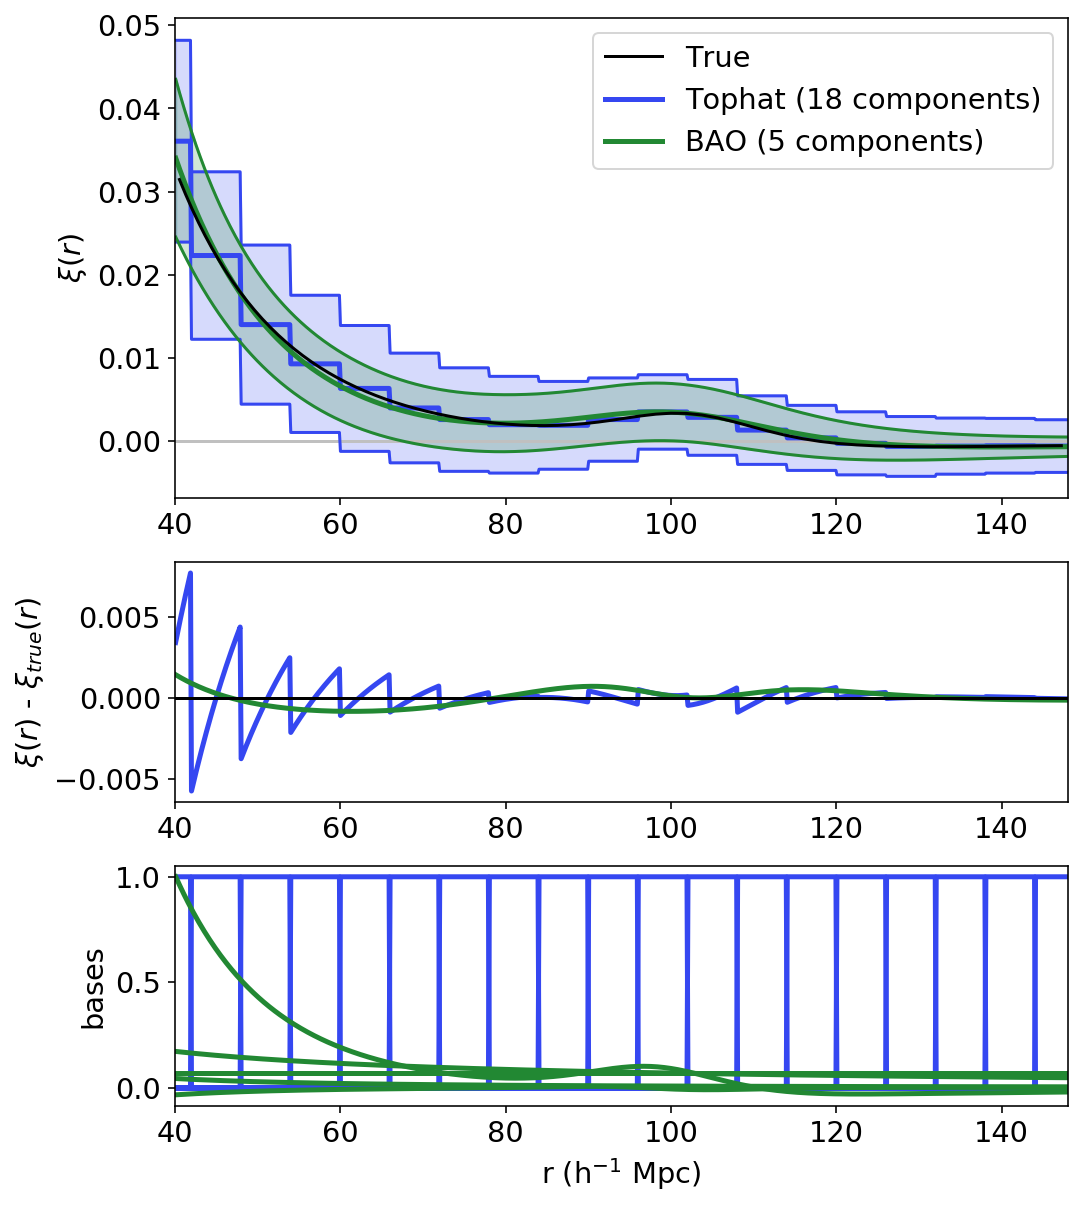

In [19]:
cat_tag = '_L750_n2e-5_z057_patchy'
cf_tags = ['_tophat_bw6', '_baoiter_cosmob17']
colors = [ctopmid, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

Number converged: 807/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


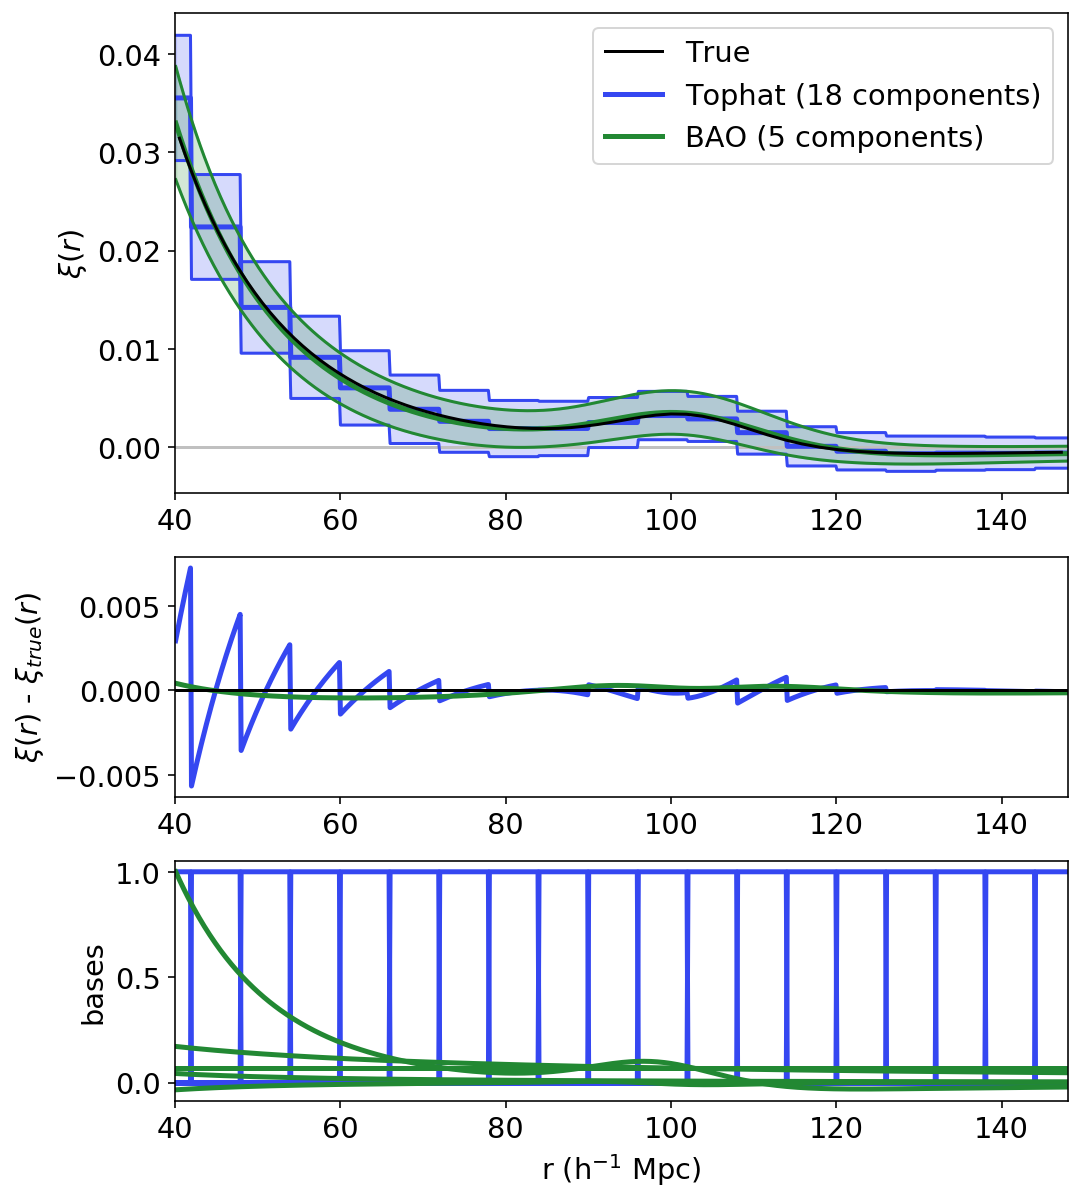

In [25]:
cat_tag = '_L750_n5e-5_z057_patchy'
cf_tags = ['_tophat_bw6', '_baoiter_cosmob17']
colors = [ctopmid, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

Number converged: 856/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


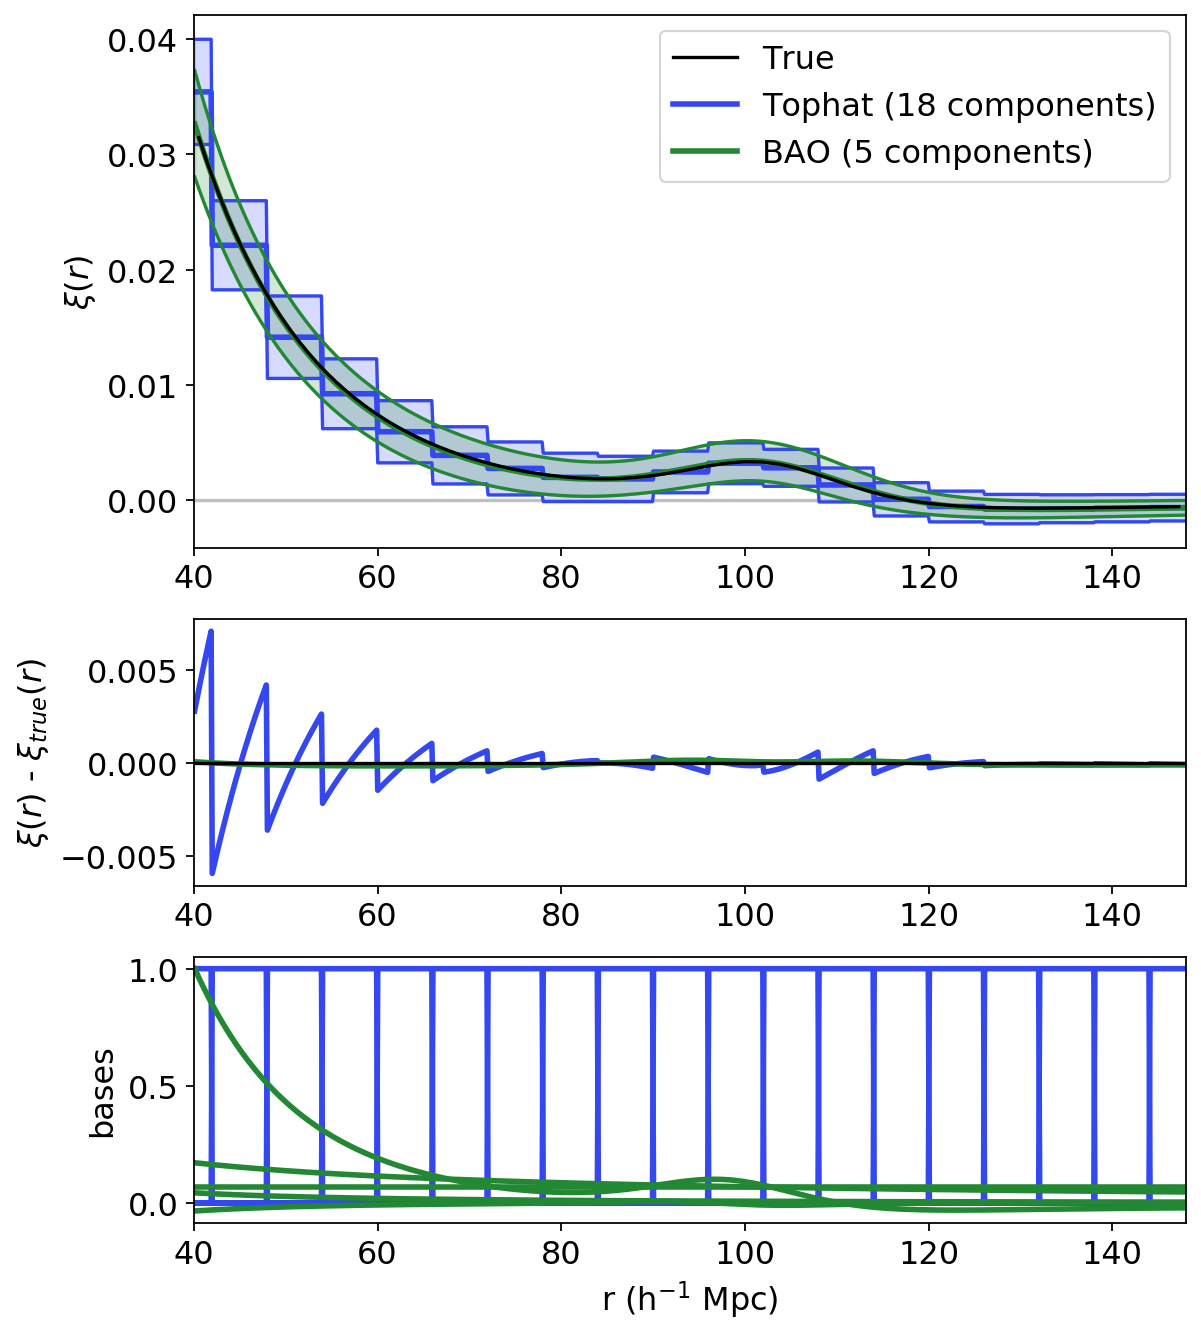

In [123]:
cat_tag = '_L750_n1e-4_z057_patchy'
cf_tags = ['_tophat_bw6', '_baoiter_cosmob17']
colors = [ctopmid, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

Number converged: 791/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


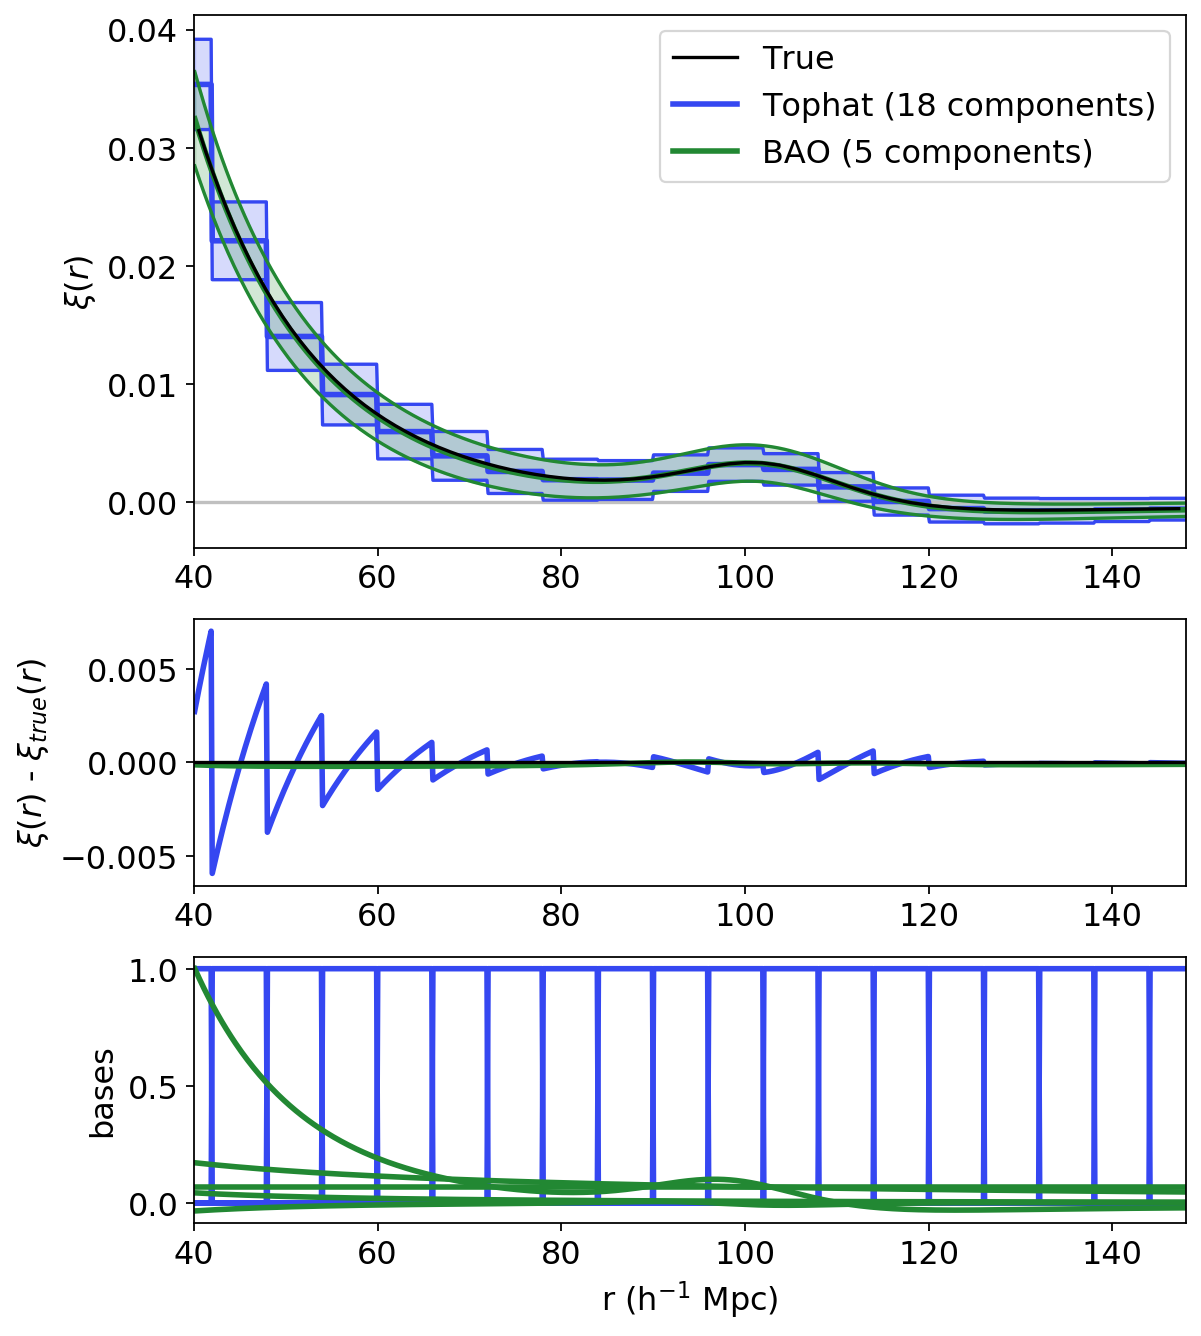

In [122]:
cat_tag = '_L750_n2e-4_z057_patchy'
cf_tags = ['_tophat_bw6', '_baoiter_cosmob17']
colors = [ctopmid, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, Nrealizations=1000, show_bases=True,
                    peak_fit=False) #True, bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

In [16]:
cat_tag = '_L750_n2e-4_z057_patchy'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))

Found 123 converged BAO cfs (877 not converged)
alpha_mean: 0.9980515080699847
alpha_median: 0.9996431307332457
alpha_std: 0.026805063224202497
0.9980515080699847 0.9996431307332457 0.026805063224202497


In [17]:
cat_tag = '_L750_n2e-5_z057_patchy'
cf_tag = '_theory_bw6'
cosmo_base = bao_utils.get_cosmo('patchy')
Nrealizations = 1000
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))
print(np.nanmean(alphas_standard), np.nanmedian(alphas_standard), np.nanstd(alphas_standard))

0.258909 0.307115 0.048206 0.6777 0.9611 [] 0.8288000000000002 3.046
Optimal parameters for realization 92 not found! continuing
Optimal parameters for realization 172 not found! continuing
Optimal parameters for realization 270 not found! continuing
Optimal parameters for realization 287 not found! continuing
Optimal parameters for realization 646 not found! continuing
Optimal parameters for realization 655 not found! continuing
Optimal parameters for realization 845 not found! continuing
Optimal parameters for realization 884 not found! continuing
Optimal parameters for realization 971 not found! continuing
Optimal parameters for realization 987 not found! continuing
1.0243823553620888 1.0054074915925202 0.19935256645346647


Text(0, 0.5, '#')

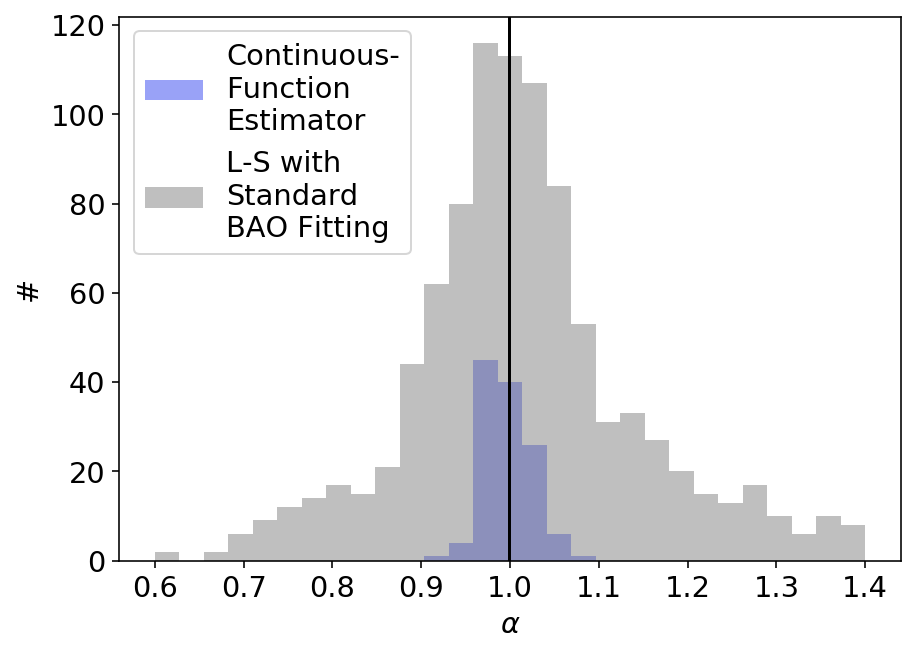

In [18]:
bins = np.linspace(0.6, 1.4, 30)
plt.figure(figsize=(7,5))
plt.hist(alphas, bins=bins, color=ctopmid, alpha=0.5, label='Continuous-\nFunction\nEstimator')
plt.hist(alphas_standard, bins=bins, color=ctheory, alpha=0.5, label='L-S with\nStandard\nBAO Fitting')
plt.axvline(alpha_true, color='black')
plt.legend(loc='upper left')
plt.xlabel(r"$\alpha$")
plt.ylabel('#')

## Check convergence

In [112]:
def load_bao(cat_tag, cf_tag, Nr):
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    xis = []
    amps = []
    extras = []
    niters = []
    assert 'baoiter' in cf_tag, "baoiter not in cf_tag!"
    fn_pattern = f"cf{cf_tag}_*{cat_tag}_rlz{Nr}.npy"
    matches = glob.glob(f'{result_dir}/{fn_pattern}')
    
    for cf_fn in matches:
        r_avg, xi, amp, proj, extra_dict = np.load(cf_fn, allow_pickle=True)
    
        rs.append(r_avg)
        xis.append(xi)
        amps.append(amp)
        extras.append(extra_dict)

        fn_split = cf_fn.split('_')
        for nn in fn_split:
            if nn.startswith('niter'):
                niter = int(nn[len('niter'):])
                niters.append(niter)
    print(niters)           
    return rs, xis, amps, extras, niters

In [116]:
cat_tag = '_L750_n2e-4_z057_patchy'
cf_tag = '_baoiter_cosmob17'
Nr = 850
r_arr, xi_arr, amps_arr, extra_arr, niters = load_bao(cat_tag, cf_tag, Nr)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [117]:
alpha_results = [extra_arr[n]['alpha_result'] for n in range(len(niters))]

In [118]:
errs = [abs(extra_arr[n]['alpha_model']-extra_arr[n]['alpha_result'])/extra_arr[n]['alpha_model'] 
        for n in range(len(niters))]

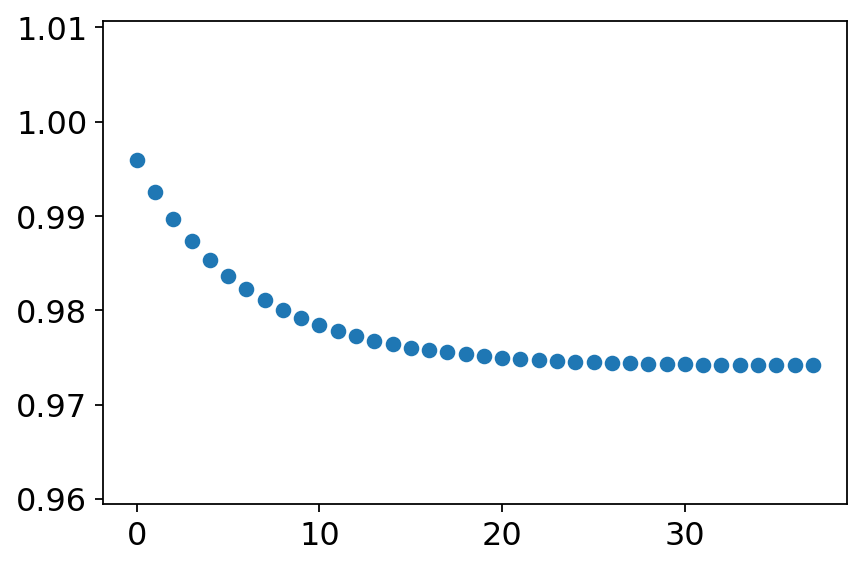

In [119]:
plt.scatter(niters, alpha_results)

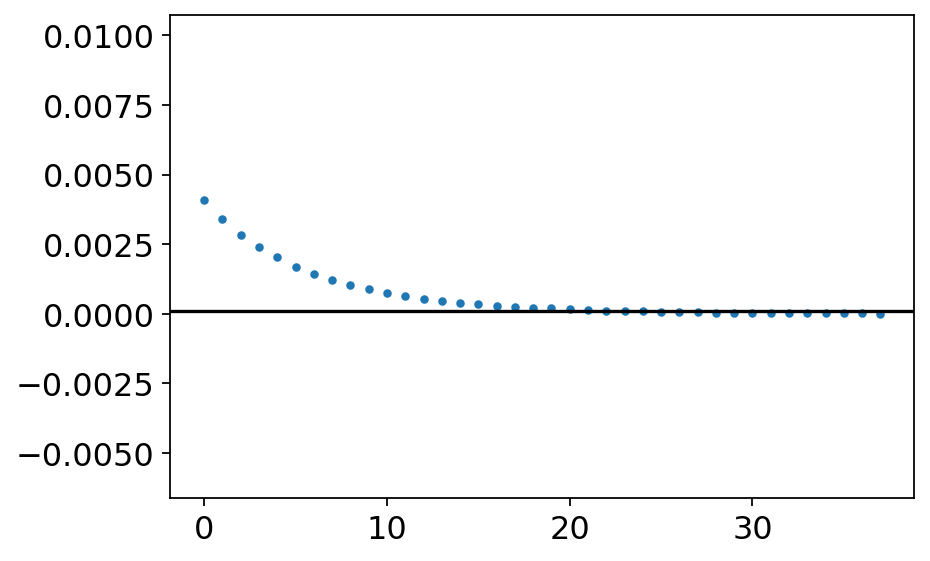

In [120]:
plt.scatter(niters, errs, s=8)
plt.axhline(0.0001, color='k')

(-0.001, 0.001)

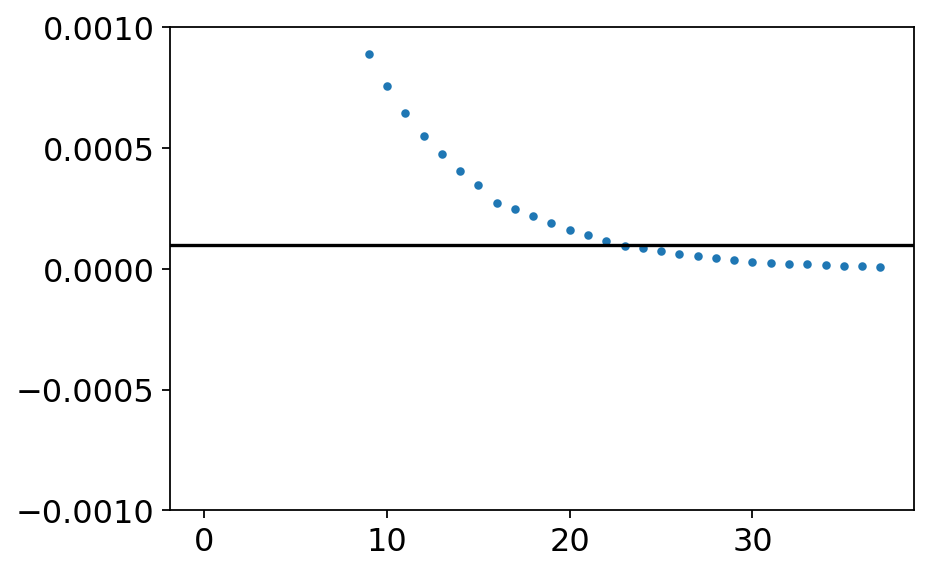

In [121]:
plt.scatter(niters, errs, s=8)
plt.axhline(0.0001, color='k')
plt.ylim(-0.001, 0.001)